In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model 
import matplotlib.pyplot as plt
%matplotlib inline

## 数据处理

In [2]:
# 加载100w行数据，并设置列名，第0列是label，1-13列 实数值特征，14-39列 稀疏类别特征
data = pd.read_csv('../dac/criteo_100w.txt', sep='\t', header=None)
dense_col = ['I' + str(i) for i in range(1, 14)]
sparse_col = ['C' + str(i) for i in range(1, 27)]
data.columns = ['label'] + dense_col + sparse_col
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [3]:
# 处理连续值特征
# nan补0
data[dense_col] = data[dense_col].fillna(0.0)
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data[dense_col] = scaler.fit_transform(data[dense_col])
# data.head()

In [4]:
# 处理稀疏类别特征
data[sparse_col] = data[sparse_col].fillna("-1")
for fea in sparse_col:
    encoder = LabelEncoder();
    data[fea] = encoder.fit_transform(data[fea])
# data.head()

## 模型构建

#### FM：一阶特征

In [5]:
# 实数值特征直接作为输入
dense_inputs = []
for fea in dense_col:
    _input = Input([1], name=fea)
    dense_inputs.append(_input)
dense_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I9')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I12')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'I13')>]

In [6]:
# 拼接实数值输入，并构建dense层
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)  # (None, 13)
first_order_dense_layer = Dense(1)(concat_dense_inputs)  # (None, 1)
first_order_dense_layer

Metal device set to: Apple M1 Pro


2022-09-23 23:13:22.541556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-23 23:13:22.541691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>

In [7]:
# 稀疏类别特征，embed 为 dense特征
# 这里利用了tf的embedding_lookup实现对one-hot编码的稀疏特征的映射，避免线性模型的权重计算
# 每个特征，构建一个embedding向量，维度为 (特征取值个数，1)。如性别 -1，0，1，可以构建（3，1）向量

sparse_inputs = []
for fea in sparse_col:
    _input = Input([1], name = fea)
    sparse_inputs.append(_input)  # 稀疏特征值输入，_input 大小 (None, 1)
sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_col[i]
    voc_sise = data[f].nunique()  # 特征取值个数，决定embedding 维度
    _embed = Flatten()(Embedding(voc_sise+1, 1, embeddings_regularizer=regularizers.l2(0.5))(_input))  # (None, 1)
    sparse_1d_embed.append(_embed)
sparse_1d_embed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_9')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten_11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '

In [8]:
first_order_sparse_layer = Add()(sparse_1d_embed)
first_order_sparse_layer

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'add')>

In [9]:
# 线性累加 实数值特征 和 稀疏类别特征
linear_part = Add()([first_order_dense_layer, first_order_sparse_layer])
linear_part

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'add_1')>

#### FM：二阶特征

In [10]:
# 对稀疏类别特征进行 k 维emebdding，每个特征表示为一个k维向量
k=16
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_col[i]
    voc_sise = data[f].nunique()  # 特征取值个数，决定embedding 维度
    _embed = Embedding(voc_sise+1, k, embeddings_regularizer=regularizers.l2(0.5))(_input)  # (None, 1, k)
    sparse_kd_embed.append(_embed)
sparse_kd_embed

[<KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_26')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_27')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_28')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_29')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_30')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_31')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_32')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_33')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_34')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_35')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'embedding_36')>,
 <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by laye

In [11]:
# 二阶交叉
# 26个稀疏类别特征拼接
concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed)  # (None, n, k), n=26
concat_sparse_kd_embed

<KerasTensor: shape=(None, 26, 16) dtype=float32 (created by layer 'concatenate_1')>

In [12]:
# 根据FM计算公式，计算交叉
# 先求和再平方
sum_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)  # (None, k)
square_sum_kd_embed = Multiply()([sum_kd_embed, sum_kd_embed])  # (None, k)

# 平方在求和
square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed])  # (None, n, k)
sum_suqare_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed)  # (None, k)

# 相减/2
sub = Subtract()([square_sum_kd_embed, sum_suqare_kd_embed]) 
sub = Lambda(lambda x: x*0.5)(sub)
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)  # (None, 1)
snd_order_sparse_layer

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lambda_3')>

#### DNN

In [13]:
# DNN 和 FM共享输入embedding
flatten_sparse_embed = Flatten()(concat_sparse_kd_embed)  # (None, n*k=26*16=416)
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(flatten_sparse_embed))  # (None, 256)
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(fc_layer))  # (None, 256)
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(fc_layer))  # (None, 256)
fc_layer_output = Dense(1)(fc_layer)  # (None, 1)

#### DeepFM

In [14]:
output_layer = Add()([linear_part, snd_order_sparse_layer, fc_layer_output])
output_layer = Activation('sigmoid')(output_layer)
output_layer

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activation')>

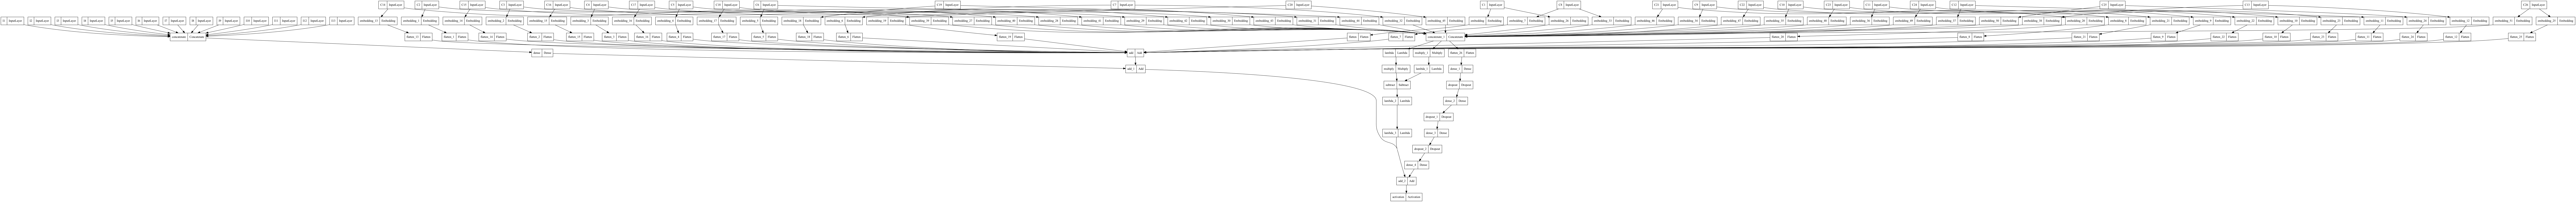

In [15]:
# 编译模型，并打印模型结构
model = Model(dense_inputs + sparse_inputs, output_layer)
plot_model(model, 'deepfm.png')

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 C1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 C2 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 C3 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 C4 (InputLayer)                [(None, 1)]          0           []                               
                                                                                              

 embedding_40 (Embedding)       (None, 1, 16)        142960      ['C15[0][0]']                    
                                                                                                  
 embedding_41 (Embedding)       (None, 1, 16)        3294800     ['C16[0][0]']                    
                                                                                                  
 embedding_42 (Embedding)       (None, 1, 16)        176         ['C17[0][0]']                    
                                                                                                  
 embedding_43 (Embedding)       (None, 1, 16)        62112       ['C18[0][0]']                    
                                                                                                  
 embedding_44 (Embedding)       (None, 1, 16)        29696       ['C19[0][0]']                    
                                                                                                  
 embedding

                                                                                                  
 I11 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 I12 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 I13 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 1)         1262        ['C1[0][0]']                     
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 1)         532         ['C2[0][0]']                     
          

                                                                                                  
 flatten_2 (Flatten)            (None, 1)            0           ['embedding_2[0][0]']            
                                                                                                  
 flatten_3 (Flatten)            (None, 1)            0           ['embedding_3[0][0]']            
                                                                                                  
 flatten_4 (Flatten)            (None, 1)            0           ['embedding_4[0][0]']            
                                                                                                  
 flatten_5 (Flatten)            (None, 1)            0           ['embedding_5[0][0]']            
                                                                                                  
 flatten_6 (Flatten)            (None, 1)            0           ['embedding_6[0][0]']            
          

 lambda_2 (Lambda)              (None, 16)           0           ['subtract[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['dense_3[0][0]']                
                                                                                                  
 add_1 (Add)                    (None, 1)            0           ['dense[0][0]',                  
                                                                  'add[0][0]']                    
                                                                                                  
 lambda_3 (Lambda)              (None, 1)            0           ['lambda_2[0][0]']               
                                                                                                  
 dense_4 (Dense)                (None, 1)            257         ['dropout_2[0][0]']              
          

## 模型训练

In [17]:
from tensorflow.keras.callbacks import TensorBoard

In [18]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0, 
                 write_graph=True,
                 write_grads=True, 
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [23]:
train_data = data.loc[:500000-1]
valid_data = data.loc[500000:]
train_data.shape, valid_data.shape

((500000, 40), (500000, 40))

In [24]:
train_dense_x = [train_data[f].values for f in dense_col]
train_sparse_x = [train_data[f].values for f in sparse_col]
train_label = [train_data['label'].values]

In [25]:
val_dense_x = [valid_data[f].values for f in dense_col]
val_sparse_x = [valid_data[f].values for f in sparse_col]
val_label = [valid_data['label'].values]

In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])
model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=5, batch_size=256,
          validation_data=(val_dense_x+val_sparse_x, val_label),
          callbacks=[tbCallBack]
         )

Epoch 1/5


2022-09-23 23:27:43.335430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1954/1954 [==============================] - 316s 161ms/step - loss: 0.6857 - binary_crossentropy: 0.5124 - auc: 0.7130
Epoch 2/5
1954/1954 [==============================] - 317s 162ms/step - loss: 0.6712 - binary_crossentropy: 0.5107 - auc: 0.7166
Epoch 3/5
 723/1954 [==========>...................] - ETA: 3:20 - loss: 0.6547 - binary_crossentropy: 0.5098 - auc: 0.7153